# Importando Bibliotecas

In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

#Plot
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

# Processamento
import numpy as np
import random
import pandas as pd
import time
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import itertools

# Outros
import warnings

In [2]:
warnings.filterwarnings("ignore", message="Do not pass an `input_shape`/`input_dim` argument to a layer.")

Definindo uma seed padrão, para manter uma constância nos resultados, caso seja necessário rodar o projeto novamente

In [3]:
seed = 42
np.random.seed(seed)
random.seed(seed)

Selecionando o dispositivo para rodar o projeto (Prefencialmente GPU)

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# Carregando e Processando os Dados

Iremos trabalhar com o valor de fechamento do BTC no dia, então iremos remover o valor de abertura do dataset

In [57]:
dataset = pd.read_csv('../data/Bitstamp_BTCUSD_d.csv')

Transformando a coluna *date* para o formato de dateTime


In [58]:
dataset['date'] = pd.to_datetime(dataset['date'])

dataset

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1717459200,2024-06-04,BTC/USD,68798.00,68868.00,68792.00,68857.00,6.283420e-01,4.326574e+04
1,1717372800,2024-06-03,BTC/USD,67744.00,70268.00,67590.00,68801.00,2.391376e+03,1.645291e+08
2,1717286400,2024-06-02,BTC/USD,67722.00,68405.00,67281.00,67752.00,5.443606e+02,3.688152e+07
3,1717200000,2024-06-01,BTC/USD,67513.00,67810.00,67387.00,67723.00,3.686240e+02,2.496433e+07
4,1717113600,2024-05-31,BTC/USD,68330.00,69010.00,66624.00,67477.00,1.880059e+03,1.268607e+08
...,...,...,...,...,...,...,...,...,...
3472,1417478400,2014-12-02,BTC/USD,378.39,382.86,375.23,379.25,2.593576e+06,6.832530e+03
3473,1417392000,2014-12-01,BTC/USD,376.40,382.31,373.03,378.39,2.520662e+06,6.660560e+03
3474,1417305600,2014-11-30,BTC/USD,376.57,381.99,373.32,373.34,1.145567e+06,3.046330e+03
3475,1417219200,2014-11-29,BTC/USD,376.42,386.60,372.25,376.72,2.746157e+06,7.245190e+03


Podemos verificar que a coluna 'symbol' apenas um único valor para todas as instâncias, por isso vamor removê-la, esse valor inclusive não será importante na predição

In [59]:
dataset['symbol'].describe()

count        3477
unique          1
top       BTC/USD
freq         3477
Name: symbol, dtype: object

In [60]:
dataset.drop(['symbol'], axis=1, inplace=True)

Agora iremos configurar a coluna de data para ser o index do dataset. Além disso, iremos remover instâncias que possuem alguma coluna com valor NA ou que sejam duplicatas.

In [61]:
# Configura a coluna de data como index do Dataframe
dataset.set_index('date', inplace=True, drop=False)
dataset = dataset.reset_index(drop=True)

# Verificar e remover valores nulos
dataset = dataset.dropna()

# Verificar e remover duplicatas
dataset = dataset.drop_duplicates()


# Reordenar o dataset
dataset = dataset.sort_values(by='date', ascending=True)

# Análise Exploratória

In [62]:
dataset

,unix,date,open,high,low,close,Volume BTC,Volume USD
3476,1417132800,2014-11-28,363.59,381.34,360.57,376.28,3.220878e+06,8.617150e+03
3475,1417219200,2014-11-29,376.42,386.60,372.25,376.72,2.746157e+06,7.245190e+03
3474,1417305600,2014-11-30,376.57,381.99,373.32,373.34,1.145567e+06,3.046330e+03
3473,1417392000,2014-12-01,376.40,382.31,373.03,378.39,2.520662e+06,6.660560e+03
3472,1417478400,2014-12-02,378.39,382.86,375.23,379.25,2.593576e+06,6.832530e+03
...,...,...,...,...,...,...,...,...
4,1717113600,2024-05-31,68330.00,69010.00,66624.00,67477.00,1.880059e+03,1.268607e+08
3,1717200000,2024-06-01,67513.00,67810.00,67387.00,67723.00,3.686240e+02,2.496433e+07
2,1717286400,2024-06-02,67722.00,68405.00,67281.00,67752.00,5.443606e+02,3.688152e+07
1,1717372800,2024-06-03,67744.00,70268.00,67590.00,68801.00,2.391376e+03,1.645291e+08


Pegando o número de linhas equivalente a 20% do dataset. Essa quantidade será importante para definir o tamanho do conjunto de treinamento e teste

In [63]:
num_linhas = int(len(dataset) * 0.8)

### Plotando o valor de BTC ao longo do tempo

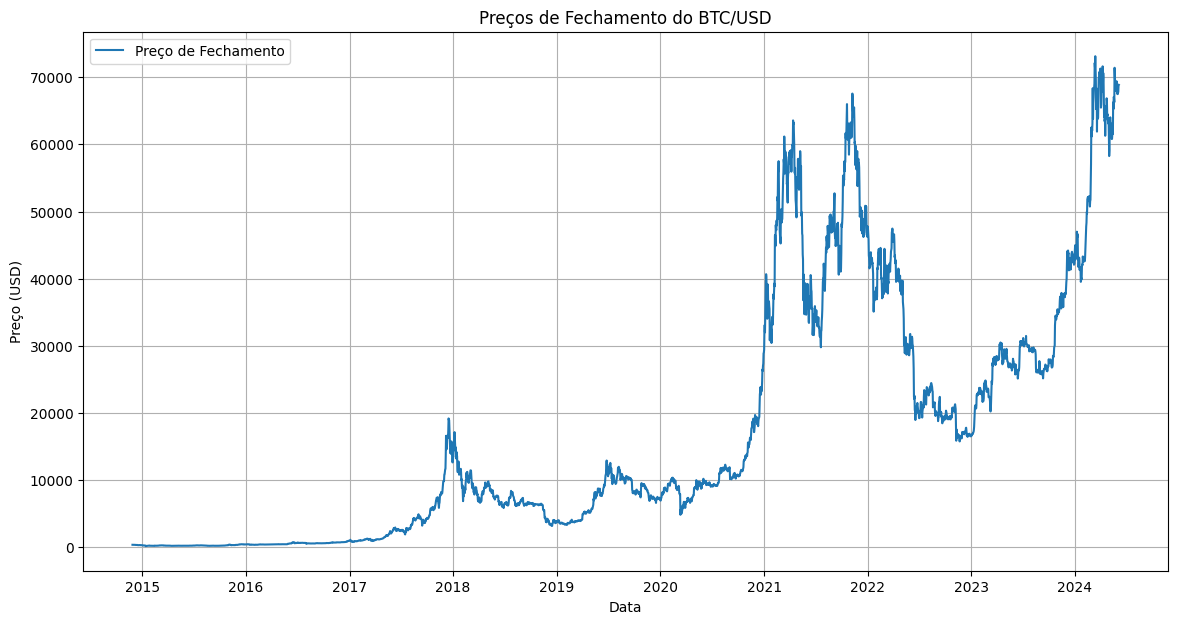

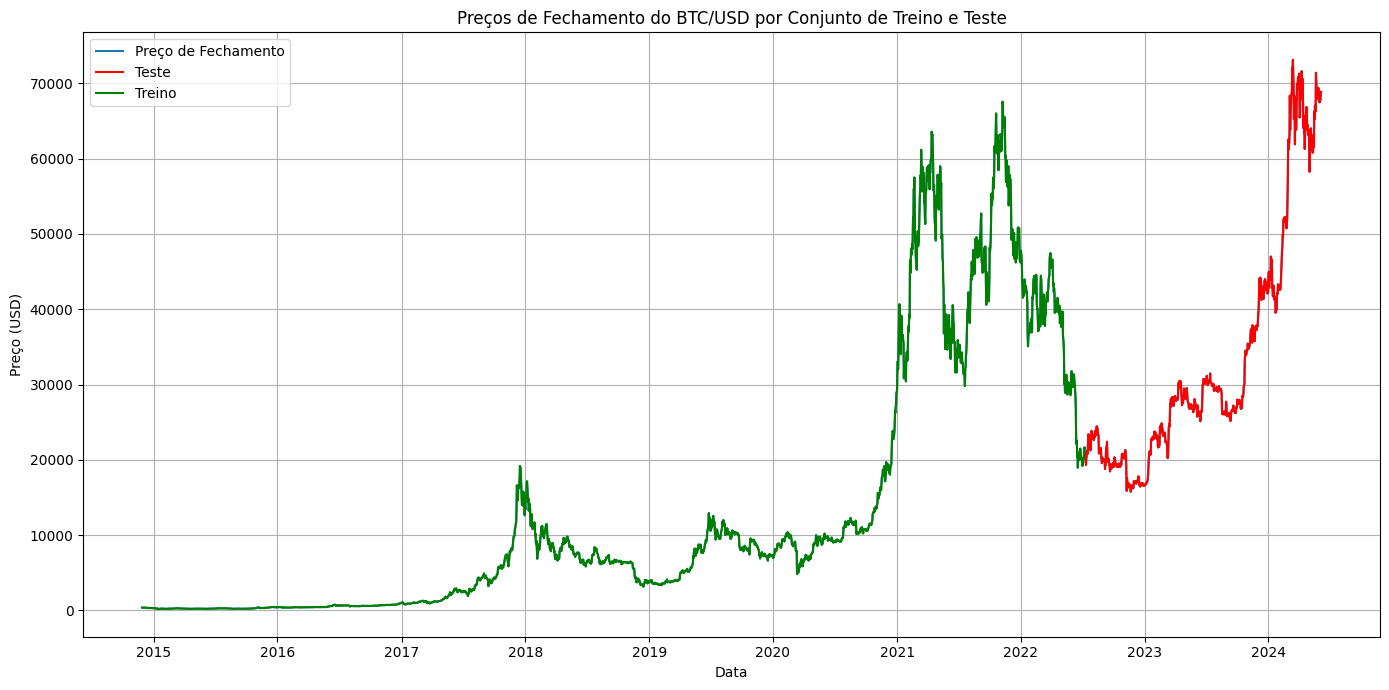

In [64]:
# Plotar os preços de fechamento ao longo do tempo
plt.figure(figsize=(14, 7))
plt.plot(dataset['date'], dataset['close'], label='Preço de Fechamento')
plt.title('Preços de Fechamento do BTC/USD')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)

# Plotar os preços de fechamento do conjunto de treino e teste
plt.figure(figsize=(14, 7))
plt.plot(dataset['date'], dataset['close'], label='Preço de Fechamento')
plt.plot(dataset.iloc[num_linhas:]['date'], dataset.iloc[num_linhas:]['close'], label='Teste', color='red')
plt.plot(dataset.iloc[:num_linhas]['date'], dataset.iloc[:num_linhas]['close'], label='Treino', color='green')
plt.title('Preços de Fechamento do BTC/USD por Conjunto de Treino e Teste')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Plotando o volume negociado ao longo do tempo

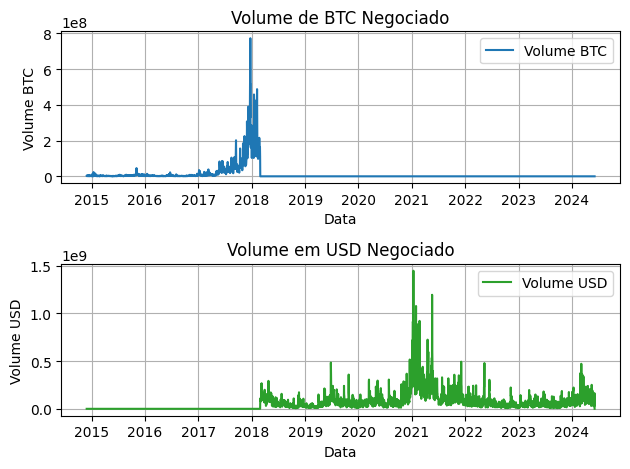

In [13]:
plt.subplot(2, 1, 1)
plt.plot(dataset['date'], dataset['Volume BTC'], label='Volume BTC', color='tab:blue')
plt.title('Volume de BTC Negociado')
plt.xlabel('Data')
plt.ylabel('Volume BTC')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(dataset['date'], dataset['Volume USD'], label='Volume USD', color='tab:green')
plt.title('Volume em USD Negociado')
plt.xlabel('Data')
plt.ylabel('Volume USD')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Exibindo a matriz de correlação entre as features do projeto

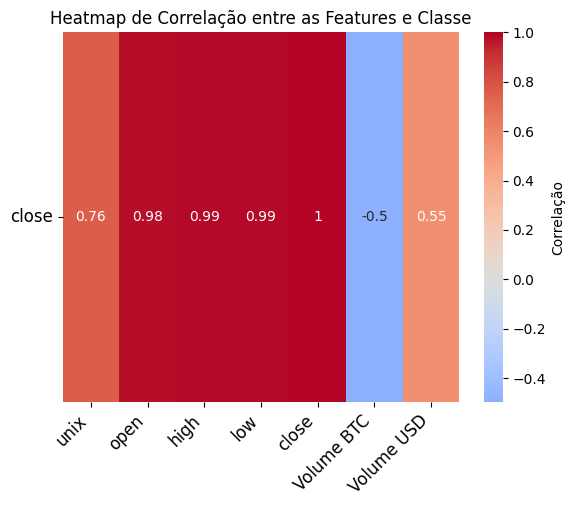

In [14]:
# Calcular a correlação entre preço e volume
correlation = dataset.corr(method='kendall', numeric_only=True)

sns.heatmap(correlation[['close']].T, annot=True, cmap='coolwarm', center=0, cbar_kws={'label': 'Correlação'})
plt.title('Heatmap de Correlação entre as Features e Classe')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.show()

Faz todo sentido que os valores de *open*, *high*, *low*, *close*, possuam uma alta correlação, uma vez que o valor do BTC não sofre grande variações ao longo dos dias, logo esses valores tendem a serem muito próximos ums dos outros, além de representarem a mesma caracteristica, o preço do BTC

# Divisão dos Dados

Retiriando dados inúteis e normalizando os dados

In [15]:
# ['date', 'unix', 'open', 'low', 'high', 'Volume USD', 'Volume BTC']
dp_dataset = dataset.drop(['date', 'unix', 'open', 'low', 'high', 'Volume USD', 'Volume BTC'], axis=1)

# Normaliza os dados
scaler = MinMaxScaler(feature_range=(0, 1))
sc_dataset = scaler.fit_transform(dp_dataset)

In [16]:
dp_dataset

,close
3476,376.28
3475,376.72
3474,373.34
3473,378.39
3472,379.25
...,...
4,67477.00
3,67723.00
2,67752.00
1,68801.00


In [17]:
sc_dataset

array([[0.00293699],
       [0.00294302],
       [0.0028967 ],
       ...,
       [0.92641072],
       [0.94078866],
       [0.94155622]])

In [18]:
sc_dataset.shape

(3477, 1)

#### Função para transformar uma série temporal em conjuntos de dados de treinamento, validação e teste para modelagem preditiva, utilizando uma janela deslizante para extrair sequências de entradas passadas e prever valores futuros.

In [19]:
def create_data(df, n_future, n_past, train_test_split_percentage, validation_split_percentage):
    n_feature = df.shape[1]
    x_data, y_data = [], []
    
    for i in range(n_past, len(df) - n_future + 1):
        x_data.append(df[i - n_past:i, 0:n_feature])
        y_data.append(df[i + n_future - 1:i + n_future, 0])
    
    split_training_test_starting_point = int(round(train_test_split_percentage * len(x_data)))
    split_train_validation_starting_point = int(round(split_training_test_starting_point * (1 - validation_split_percentage)))
    
    x_train = x_data[:split_train_validation_starting_point]
    y_train = y_data[:split_train_validation_starting_point]
    
    x_val = x_data[split_train_validation_starting_point:split_training_test_starting_point]
    y_val = y_data[split_train_validation_starting_point:split_training_test_starting_point]
    
    x_test = x_data[split_training_test_starting_point:]
    y_test = y_data[split_training_test_starting_point:]
    
    return np.array(x_train), np.array(x_test), np.array(x_val), np.array(y_train), np.array(y_test), np.array(y_val)

Criando o conjunto de test e validação a partir da definição de janela flutuante. Definindo a quantidade de dias passados serão utilizados na predição do futuro. Bem como na definição de quantos dias futuros queremos prever

In [20]:
n_future = 1 # -> Number of days you want to predict into the future
n_past = 3 # -> Number of past days you want to use to predict the future

X_train, X_test, X_val, y_train, y_test, y_val = create_data(
    sc_dataset, n_future=n_future, n_past=n_past, train_test_split_percentage=0.8, validation_split_percentage=0
)

In [21]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2779, 3, 1)
y_train shape: (2779, 1)
X_val shape: (0,)
y_val shape: (0,)
X_test shape: (695, 3, 1)
y_test shape: (695, 1)


# Treinando o Modelo LSTM

Treinando um modelo base, a fim de verificar o seu funcionamento. O modelo base tem 2 layers com 15 neurônios.

In [22]:
regressor = Sequential()
regressor.add(LSTM(units=15, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=15, return_sequences=False))
regressor.add(Dropout(0.3))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

regressor.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3, 15)          │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 15)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 15)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,896 (11.31 KB)

 Trainable params: 2,896 (11.31 KB)

 Non-trainable params: 0 (0.00 B)

Definimos um EarlyStop, com uma paciencia de 7

In [23]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

# fit model
history = regressor.fit(X_train, y_train, validation_split=0.3, epochs=75, batch_size=16, callbacks=[es])

Epoch 1/75
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0031 - root_mean_squared_error: 0.0553 - val_loss: 0.0195 - val_root_mean_squared_error: 0.1404
Epoch 2/75
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.4206e-04 - root_mean_squared_error: 0.0184 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0470
Epoch 3/75
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.1289e-04 - root_mean_squared_error: 0.0146 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0321
Epoch 4/75
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1246e-04 - root_mean_squared_error: 0.0146 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0372
Epoch 5/75
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.8860e-04 - root_mean_squared_error: 0.0137 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0405
Epoch 6/75
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7074e-04 - root_mean_squared_error: 0.0131 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0396
Epoch 7/75
122/122 ━━━━━━━━━━━━━

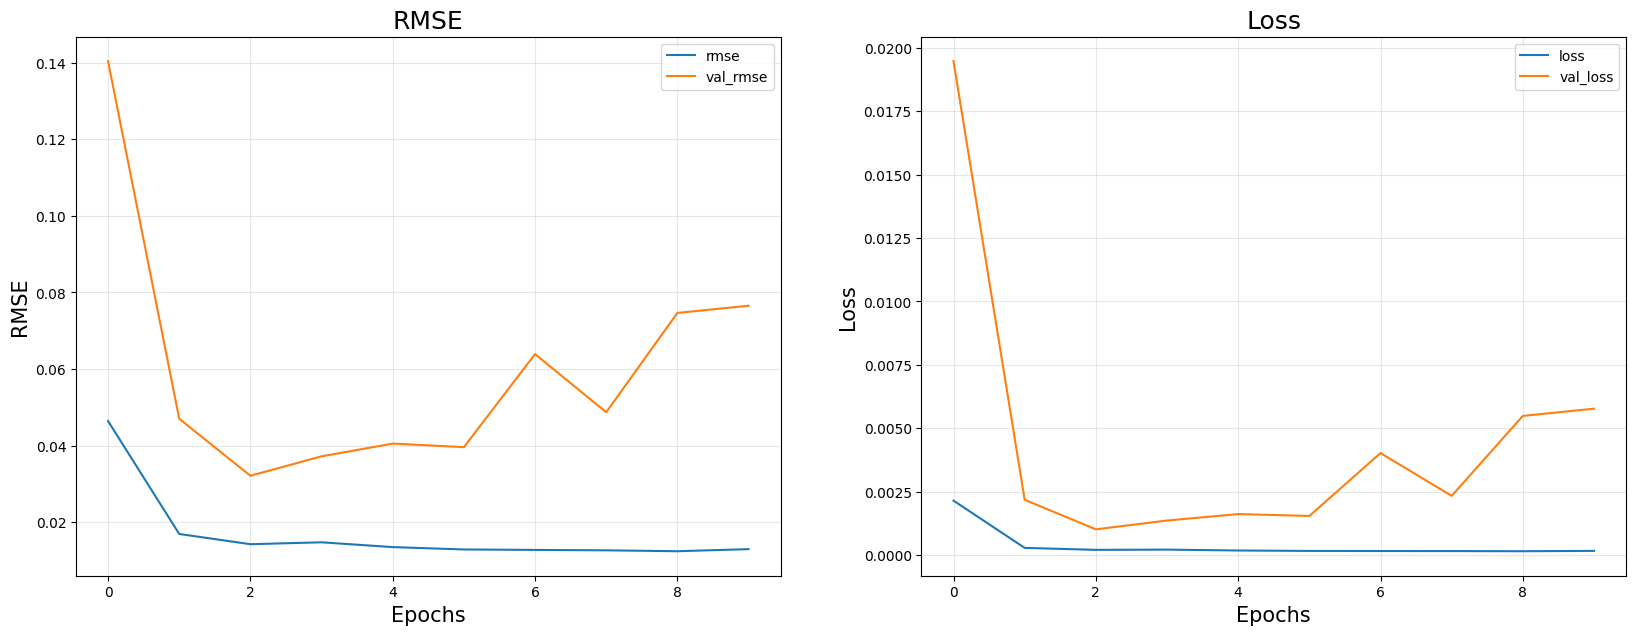

In [24]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

# Accuracy
plt.plot(history.epoch, history.history['root_mean_squared_error'], label = "rmse")
plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label = "val_rmse")

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


#Adding Subplot 1 (For Loss)
fig.add_subplot(122)

plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

# Tunning

#### Função utilizada para a afinação de hiperparâmetros testando todas as combinações possíveis de: 
- camadas adicionais
- número de neurônios
- tamanho do batch 
- taxa de dropout
  
Para isso, há o treinamento e avaliação do modelo em cada combinação, utilizando callbacks para otimizar o processo de treinamento, mantendo um earlyStop relativamente baixo. Também criamos um modelCheckpoint para ir salvando o modelo ao longo do treinamento a fim de obter um backup ao final

A função retorna um histórico (hist) contendo as configurações testadas e suas respectivas MSE de treinamento e teste.

In [25]:
def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):
    
    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout))
    
    print(possible_combinations)
    print('\n')
    
    hist = []
    
    for i in range(0, len(possible_combinations)):
        
        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')
        
        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]
        
        # instantiating the model in the strategy scope creates the model on the TPU
        #with tpu_strategy.scope():
        regressor = Sequential()
        regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation='linear'))
        regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

        file_path = f'../models/model_{i}.keras'

        mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        regressor.fit(x_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)


        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')
        
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
         
    return hist

Criação dos Conjuntos de Dados

In [26]:
n_future = 1 # -> Number of days you want to predict into the future
n_past = 3 #   -> Number of past days you want to use to predict the future

X_train, X_test, _, y_train, y_test, _ = create_data(
    sc_dataset, n_future=n_future, n_past=n_past, train_test_split_percentage=0.75, validation_split_percentage=0
)

Criando os possíveis parâmetros para o modelo, fizemos de modo a explorar possíveis combinações e camadas de neurônios, de modo que não tomasse um grande tempo de treinamento, mas que pudessemos ter uma ideia da melhor combinação de parâmetros

In [ ]:
config = [
    [False, True], # -> [first_additional_layer]
    [False, True], # -> [second_additional_layer]
    [False, True], # -> [third_additional_layer]
    [16, 32], #      -> [n_neurons]
    [8, 16, 32], #   -> [n_batch_size]
    [0.2] #          -> [dropout_rate]
]

hist = LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, y_test)

Foram realizadas 3 séries do gridsearch, a fim de variar também o número de dias passados utilizados para a previsão do resultado futuro, sendo eles 3, 7 e 14 dias. A comparação dos resultados pode ser analisada na seção `Análise do resultados Fine - Tunning`


Após o Fine-Tunning obtivemos a seguinte tabela, com os melhores resultados de treinamento

In [32]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True).reset_index()
hist.head()

,index,0,1,2,3,4,5,6,7
0,4,False,False,False,32,16,0.2,"[0.0002993274247273803, 0.017286527901887894]","[0.0009877049596980214, 0.02943768911063671]"
1,3,False,False,False,32,8,0.2,"[0.00032543798442929983, 0.01803278923034668]","[0.0011651193490251899, 0.03165939450263977]"
2,2,False,False,False,16,32,0.2,"[0.0003430304932408035, 0.01852286607027054]","[0.0013523440575227141, 0.03378817066550255]"
3,5,False,False,False,32,32,0.2,"[0.00036600427119992673, 0.019123787060379982]","[0.001399695873260498, 0.034493010491132736]"
4,11,False,False,True,32,32,0.2,"[0.0007022215286269784, 0.02643059939146042]","[0.0028035300783813, 0.048891857266426086]"


In [33]:
hist_df = hist.drop(['index'], axis=1)
hist_df.to_csv(f'../saves/{n_past}_days.csv')

Os modelos com maior número de neurônios (32) obtiveram os melhores resultados. No entanto, o número de camadas não apresentou uma grande influência no MSE, uma vez que, dos 5 melhores modelos, 2 possuíam apenas uma camada de LSTM. Isso evidencia que não é necessário uma rede muito complexa para resolver o problema.

Outro hiperparâmetro que podemos destacar é o batch_size, em que valores menores (8) resultaram em melhores desempenhos na loss do modelo. Isso pode ser explicado pelo fato de que batch_sizes menores introduzem mais variabilidade nos gradientes durante o treinamento, o que pode ajudar o modelo a escapar de mínimos locais e generalizar melhor. Em contrapartida, batch_sizes maiores fornecem atualizações mais estáveis, mas podem dificultar a capacidade do modelo de encontrar padrões, especialmente em conjuntos de dados menores.

Carregando o melhor modelo

In [35]:
idx_best_model = hist.loc[0, 'index']
print(idx_best_model)
regressor = load_model(f'../models/model_{idx_best_model}.keras')

4


# Testando o modelo

In [36]:
results = regressor.evaluate(X_test, y_test)
print("test loss, test MSE:", np.round(results, 7))

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5805e-04 - root_mean_squared_error: 0.0210 
test loss, test MSE: [0.0003911 0.0199478]


### Plotando o gráfico do valor real do BTC x Valor predizido

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step 


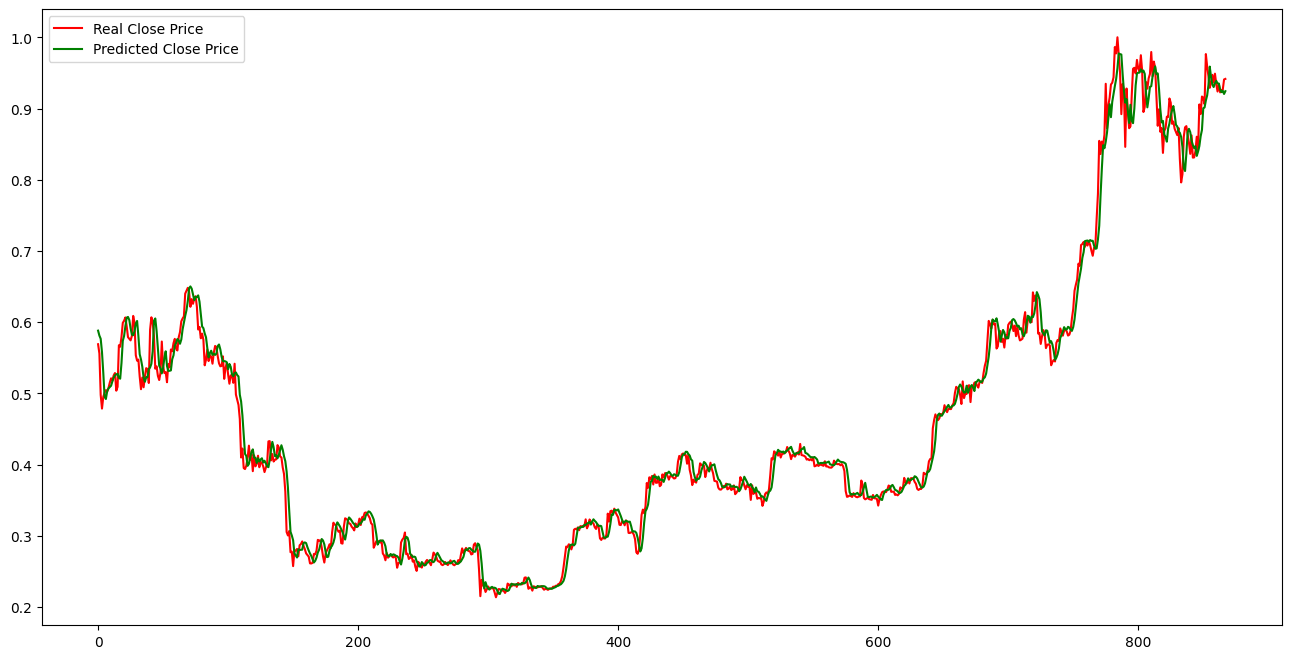

In [37]:
y_pred = regressor.predict(X_test)
y_pred = y_pred
plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(y_test, color='red', label = 'Real Close Price')
plt.plot(y_pred, color='green', label = 'Predicted Close Price')
plt.legend(loc='best')

Dado que os dados foram normalizados durante o treinamento, é possível observar que o modelo apresentou um gráfico bastante semelhante ao valor real do BTC, com uma margem de erro bastante reduzida. Sendo assim, percebe-se que o modelo foi capaz de prever bem como foi a variação do valor do BTC no período selecionado para testes, possuindo leve discrepância em períodos onde a variação real foi mais abrupta (Mas nota-se que mesmo nesses períodos o modelo ainda conseguiu prever bem a variação dos valores).

Melhor Modelo:
- Additional_layer : 1
- n_neurons: 32
- n_batch_size: 16
- dropout_rate: 0.2

MSE: 0.0294


# Análise do resultados Fine - Tunning


Realizamos o mesmo processo de fine-tuning utilizando a combinação dos parâmetros

- Um layer Adicional
- Segundo Layer Adicional
- Terceiro Layer Adicional
- Número de Neurônios
- Tamanho do Batch Size
- Dropout Rate

Além de variar esses valores, decidimos realizar o fine-tunnning variando o tamnanho da janela de dias passados utilizados para a predição futura, variamos esse valor em 3, 7 e 14. Como será exemplificado nos gráficos abaixo, a janela com 3 dias apresentou os melhor resultado, ainda assim é importante visualizar que janelas maiores apresentaram erros médios menores.

importando os datasets

In [39]:
dt_3d = pd.read_csv('../csv/saves_3d.csv')
dt_3d['window'] = 3

In [40]:
dt_7d = pd.read_csv('../csv/saves_7d.csv')
dt_7d['window'] = 7

In [41]:
dt_14d = pd.read_csv('../csv/saves_14.csv')
dt_14d['window'] = 14

Unindo os datasets

In [42]:
df = pd.concat([dt_3d, dt_14d, dt_7d], ignore_index=True)

Realizando uma limpeza e unindo alguns dados

In [44]:
df['n_additional_layer'] = df[['first_additional_layer','second_additional_layer','third_additional_layer']].sum(axis=1)
df.drop(columns=['first_additional_layer','second_additional_layer','third_additional_layer', 'Unnamed: 0'], inplace=True)

In [49]:
df['MSE'] = df['MSE'].apply(lambda x: x.split(',')[1].strip() if ',' in x else None)
df['MSE'] = df['MSE'].apply(lambda x: x[:-2])
df['MSE'] = df['MSE'].astype(float)

df['Loss'] = df['Loss'].apply(lambda x: x.split(',')[1].strip() if ',' in x else None)
df['Loss'] = df['Loss'].apply(lambda x: x[:-2])
df['Loss'] = df['Loss'].astype(float)


In [50]:
df['MSE']

0      0.029438
1      0.031659
2      0.033788
3      0.034493
4      0.048892
         ...   
139    0.171778
140    0.180379
141    0.187861
142    0.203679
143    0.215961
Name: MSE, Length: 144, dtype: float64

In [51]:
df

,n_neurons,n_batch_size,dropout_rate,Loss,MSE,window,n_additional_layer
0,32,16,0.2,0.017287,0.029438,3,0
1,32,8,0.2,0.018033,0.031659,3,0
2,16,32,0.2,0.018523,0.033788,3,0
3,32,32,0.2,0.019124,0.034493,3,0
4,32,32,0.2,0.026431,0.048892,3,1
...,...,...,...,...,...,...,...
139,16,8,0.2,0.092560,0.171778,7,1
140,32,8,0.2,0.097227,0.180379,7,2
141,32,8,0.2,0.101443,0.187861,7,3
142,16,8,0.2,0.110704,0.203679,7,3


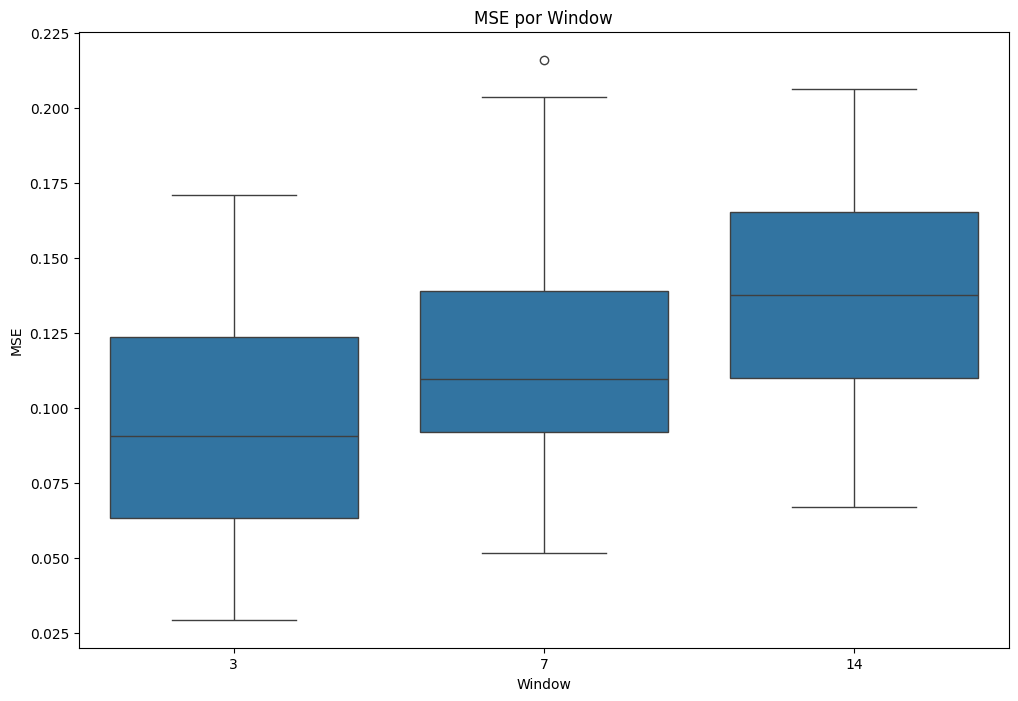

In [53]:
# Criando o boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='window', y='MSE', data=df)  # Assumindo que a coluna 7 é numérica

# Personalizando o gráfico
plt.title('MSE por Window')
plt.xlabel('Window')
plt.ylabel('MSE')

plt.show()


Como demonstrado no gráfico, os modelos com janelas de 3 dias exibem menor variabilidade no MSE em comparação com as janelas de 7 e 14 dias. Isso indica que, com janelas menores, a previsão pode ser mais estável e precisa devido à menor quantidade de dados a serem processados, permitindo um ajuste mais refinado do modelo para dados recentes.

Curiosamente, os modelos com janelas de 7 dias apresentaram maior variabilidade, com um outlier indicando que em alguns casos, a previsão pode ser menos precisa. A mediana do MSE para essa janela é ligeiramente maior que a das janelas de 3 dias, o que sugere que esse período intermediário pode não ser ideal para todas as situações.

Por outro lado, os modelos com janelas de 14 dias também mostraram uma variabilidade considerável no MSE, similar aos modelos de 7 dias, mas sem outliers significativos. Isso pode ser devido à maior quantidade de dados e complexidade envolvida, exigindo mais tempo de treinamento e potencialmente resultando em maior variabilidade nas previsões.

De modo geral, os modelos com janelas de 3 dias parecem oferecer um melhor equilíbrio entre estabilidade e precisão, enquanto janelas maiores podem introduzir mais variabilidade, possivelmente devido à complexidade adicional dos dados.

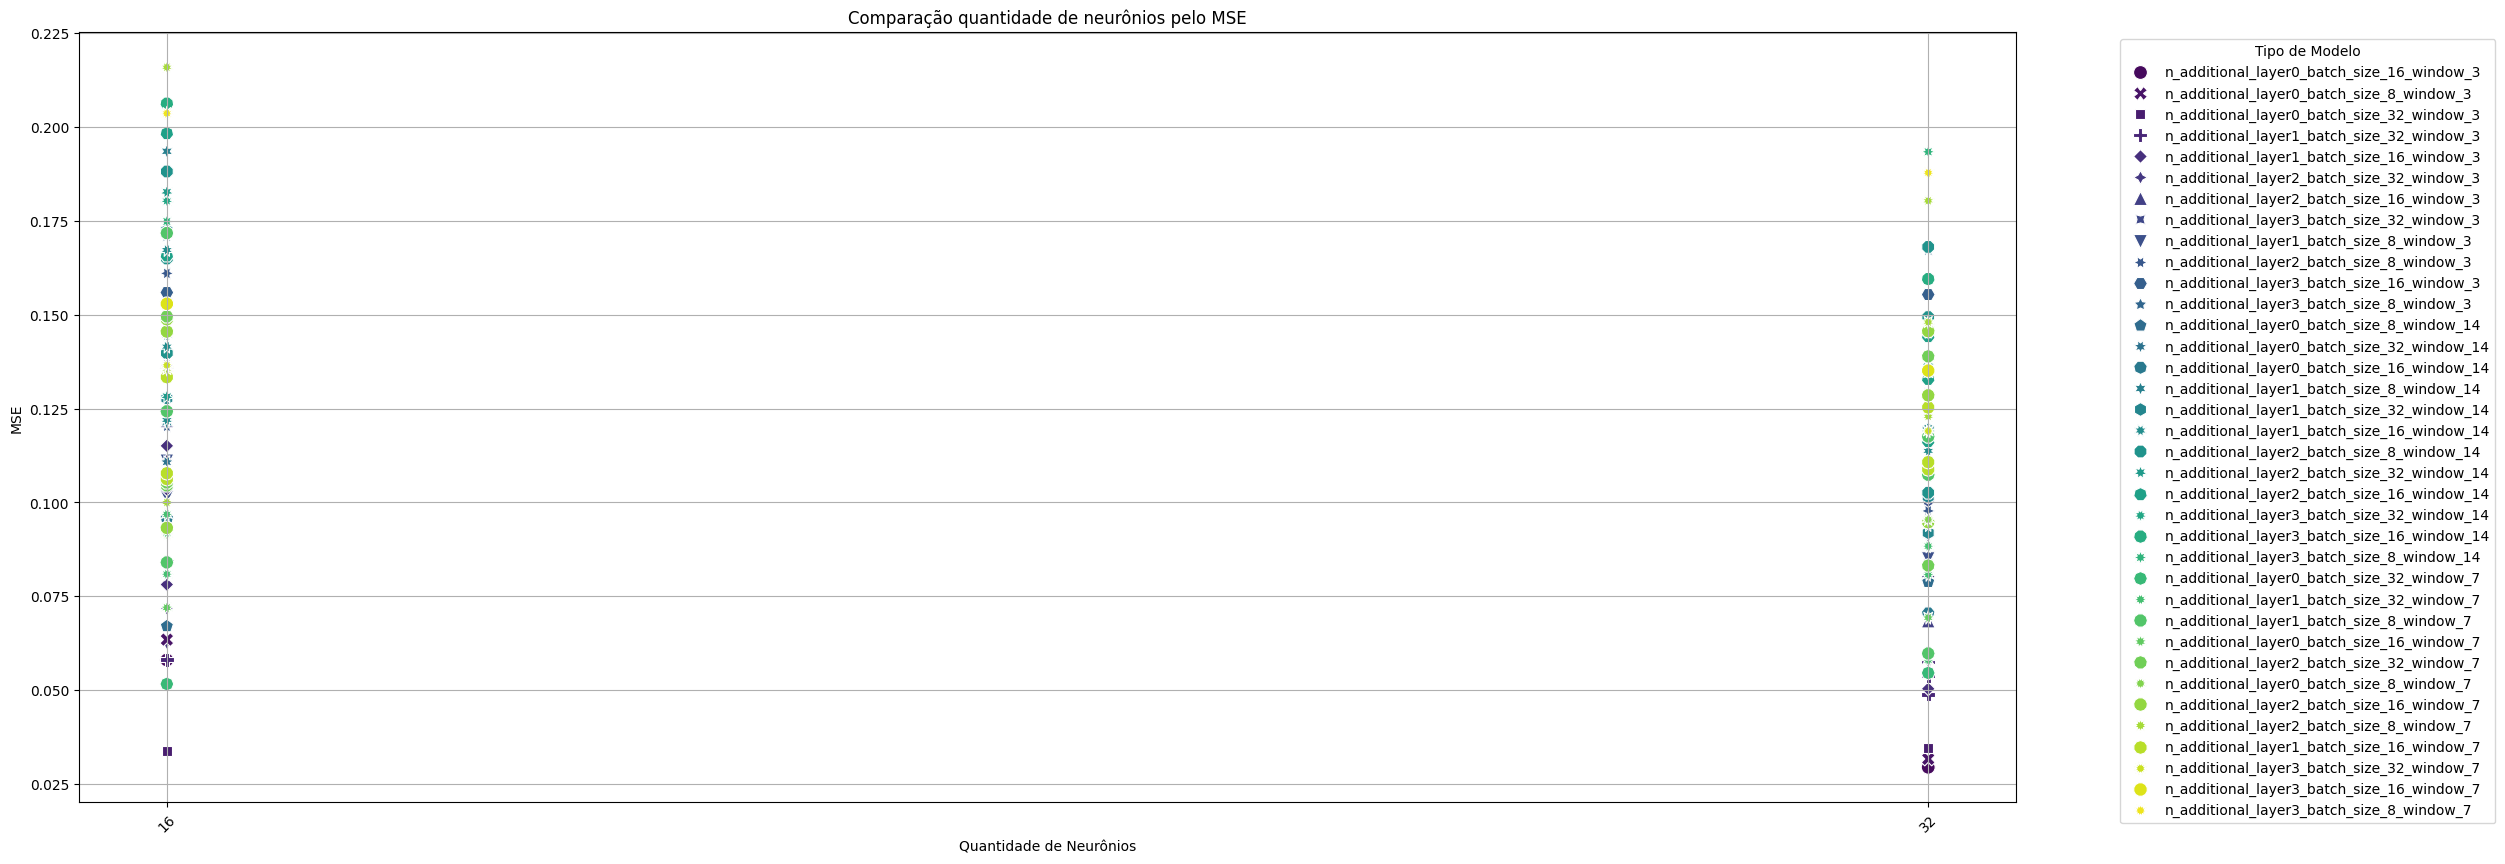

In [56]:
plt.figure(figsize=(25, 10))

df['model_type'] = ('n_additional_layer' + df['n_additional_layer'].astype(str) + 
                    '_batch_size_' + df['n_batch_size'].astype(str) + 
                    '_window_' + df['window'].astype(str))

# Plotando o gráfico de dispersão
sns.scatterplot(data=df, x='n_neurons', y='MSE', hue='model_type', style='model_type',
                markers=True, palette='viridis', s=100)

# Personalizando o gráfico
plt.title('Comparação quantidade de neurônios pelo MSE')
plt.xlabel('Quantidade de Neurônios')
plt.ylabel('MSE')

plt.xticks(rotation=45, ticks=[16,32])
plt.grid(True)
plt.legend(title='Tipo de Modelo', bbox_to_anchor=(1.05, 1), loc='upper left') 


plt.show()


Podemos observar que o aumento na quantidade de neurônios traz uma melhora siginificativa no RMSE, o que pode ser explicado pela complexiadade do problema, necessitando uma maior quantidade de neurônios para obter melhores resultados